<h1 style="color:SteelBlue; font-size:200%">Разработка модели классификации клиентов на лояльных и не лояльных</h1>

Нужно разработать модель, которая спрогнозирует уход клиента. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Импорт библиотек, функции для проекта**

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple

from category_encoders import OrdinalEncoder, TargetEncoder, CountEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool, cv

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
#функция для перестановочного A/B теста. Написана мной в другом проекте, поэтопу описание на английском
def AB_permutation_test(x, y, par='means', iterations=10000):   
    """
    This is a two-sided permutation test for the null hypothesis that 
    2 samples (x=A and y=B) have identical average values or median values 
    or variances.

    No assumption of the distribution's normality needed
    Samples can be of different sizes, independent or dependent.

    1. The test can be verified by a t-test for the means difference:
    
        scipy.stats.ttest_ind(x,y)
        pvalues should be approximately the same

        Note:
            - normal distributions needed for A, B
            - statistics are different, because 
            in t-test statistic = mean(x)-mean(y)/var(x-y) 
            and in this test statistic = abs(mean(x)-mean(y)) without var(x-y) 

    2. The test can be verified by a Fisher distribution for the variances 
    ratio:
    
        scipy.special.fdtrc(dfn, dfd, f)
        dfn = len(x) - 1
        dfd = len(y) - 1
        f = np.var(x) / np.var(y)
        statistics and pvalues should be approximately the same

        Notes: 
            - normal distributions needed for A, B

    Parameters
    ----------
    
    x : array_like
        A sample.
    
    y : array_like
        B sample.
    
    par : str, optional
        Type of test statistic:
        'means': the absolute difference between the means
        statistic = abs(mean(x) - mean(y))
        
        'medians': the absolute difference between the medians
        statistic = abs(median(x) - median(y))
        
        'variances': the ratio of the variances
        if var(x) > var(y)
        statistic = var(x) / var(y)
        if var(x) < var(y)
        statistic = var(y) / var(x)
        
        The default is 'means'.
    
    iterations : integer, optional
        Number of permutations. The default is 1000.

    Returns
    -------
    named tuple (statistic, iterations, pvalue).
    
    statistic: float
        The computed statistic of the test.
        
        'means_difference' = abs(mean(x) - mean(y))
        'medians_difference' = abs(median(x) - median(y))
        'variances_ratio' = var(x) / var(y)

    itertions: int
        Number of permutations  
        
    pvalue: float
        The two-tailed p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
   
    """
    k = 0
    size_a = len(x)
    a=np.asarray(x) 
    b=np.asarray(y)
    alldata = np.concatenate((a, b))
    
    if par == 'means':
        statistic = 'means_difference'
        diff = np.mean(a) - np.mean(b)
    elif par == 'medians':
        statistic = 'medians_difference'
        diff = np.median(a) - np.median(b)
    elif par == 'variances':
        statistic = 'variances_ratio'
        var_a = np.var(a, ddof=1)
        var_b = np.var(b, ddof=1)
        var_1 = max(var_a, var_b)
        var_2 = min(var_a, var_b)
        diff = var_1 / var_2
    else:
        return "ERROR. Incorrect 'par' value. Use par='means' or 'medians' or 'variances'."
    
    abs_diff = abs(diff)
  
    for i in range (0, iterations):
        np.random.shuffle(alldata) #перемешиваю
        if par == 'means':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'medians':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'variances':
            abs_random_diff = np.var(alldata[:size_a], ddof=1) / np.var(alldata[size_a:], ddof=1)
        
        k += abs_diff < abs_random_diff
        
    pvalue = k / iterations
       
    ABPermutationResult = namedtuple('AB_PermutationResult', (statistic, 'iterations', 'pvalue'))
    
    return ABPermutationResult(diff, iterations, pvalue)

In [3]:
def print_report(true, predicted_proba, threshold):
    
    predicted = (predicted_proba >= threshold)*1
    report = classification_report(true, predicted)
    roc_auc = roc_auc_score(true, predicted_proba)
    acc = accuracy_score(true, predicted)

    cm = confusion_matrix(true, predicted)
    cm_df = pd.DataFrame(data=cm, index=['Actual NO', 'Actual YES'], columns = ['Predicted NO', 'Predicted YES'])
    display(cm_df)
    print(f'{"report":-^60}\n\n', report)
    print( 'ROC_AUC:', round(roc_auc,2) )
    print( 'ACCURACY:', round(acc,2) )

In [4]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

<h1 style="color:SteelBlue; font-size:200%">1. Загрузка, анализ и подготовка данных</h1>

<h2 style="color:DodgerBlue">1.1 Общая информация, осмотр данных</h2>

In [5]:
link = '/home/jovyan/work/data/telecom/'
data = {}
name_list = ['contract', 'personal', 'phone', 'internet']

for name in name_list:
    name_link = os.path.join(link + name + '.csv')
    try:
        data[name] = pd.read_csv(name_link, parse_dates=['BeginDate', 'EndDate'])
    except:
        data[name] = pd.read_csv(name_link)
    print(color.BOLD + color.BLUE + name + color.END)
    display(data[name].head())

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
for name in name_list:
    print('\n'+ color.BOLD + color.BLUE + name + color.END + '\n')
    print(data[name].info())


contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None

personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender        

In [7]:
print(color.BOLD + color.BLUE + 'Duplicates in whole data:' + color.END)
for name in name_list:
    print(data[name].duplicated().sum(), name)

Duplicates in whole data:
0 contract
0 personal
0 phone
0 internet


In [8]:
print(color.BOLD + color.BLUE + 'Duplicates in customerID column:'+ color.END)
for name in name_list:
    print(data[name]['customerID'].duplicated().sum(), name)

Duplicates in customerID column:
0 contract
0 personal
0 phone
0 internet


Информация о договорах актуальна на 1 февраля 2020, заполню No в таблице 'contract' - 'EndDate' указанной датой

In [9]:
data['contract']['EndDate'].replace({'No': '2020-02-01 00:00:00'},inplace=True)
data['contract']['EndDate'] = pd.to_datetime(data['contract']['EndDate'])
data['contract'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [10]:
data['contract'].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Данные из состоят из 4 файлов, дублей нет ни в строках, ни в идентификаторах пользователей. Во всех датасетах присутствует признак customerID, по нему их можно объединить для получения полного набора признаков. Примерно для 1500 клиентов нет данных об internet, видимо, они не пользуются. А часть клиентов, похоже, не пользуется телефоном.
Пропусков нет, но часть признаков заполнены неоднородными данными (TotalCharges, EndDate), что указывает на потенциальные пропуски.

<h2 style="color:DodgerBlue">1.2 Создание целевой переменной, разведочный анализ данных договора</h2>

Создам целевую переменную. Клиенты, у которых на момент 2020-02-01 контракт завершён - ушли. И рассчитаю время пользования тарифом в месяцах, месяц начала пользования и месяц окончания пользования тарифом. Дата начала и завершения пользоваия тарифом у всех одинаковая - 1 число:

In [11]:
print('Числа начала и окончания пользования тарифом:')
print(data['contract']['BeginDate'].dt.day.value_counts())
print(data['contract']['EndDate'].dt.day.value_counts())

Числа начала и окончания пользования тарифом:
1    7043
Name: BeginDate, dtype: int64
1    7043
Name: EndDate, dtype: int64


In [12]:
data['contract']['begin_month'] = data['contract']['BeginDate'].dt.month
data['contract']['end_month'] = data['contract']['EndDate'].dt.month
data['contract']['begin_year'] = data['contract']['BeginDate'].dt.year
data['contract']['end_year'] = data['contract']['EndDate'].dt.year
data['contract']['usage_time'] = \
((data['contract']['EndDate'] - data['contract']['BeginDate']) / np.timedelta64(1, 'M')).astype('int')
data['contract'].loc[:, 'label'] = (data['contract']['EndDate'] != '2020-02-01').astype(int)

In [13]:
data['contract'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   begin_month       7043 non-null   int64         
 9   end_month         7043 non-null   int64         
 10  begin_year        7043 non-null   int64         
 11  end_year          7043 non-null   int64         
 12  usage_time        7043 non-null   int64         
 13  label             7043 non-null   int64         
dtypes: datetime64[ns](2), fl

In [14]:
data['contract'].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_month,end_month,begin_year,end_year,usage_time,label
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,2,2020,2020,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,4,2,2017,2020,34,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,10,12,2019,2019,2,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,5,2,2016,2020,45,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9,11,2019,2019,2,1


В TotalCharges, похоже, есть текст, обозначающий отсутствие данных. Преобразую столбец в числовой формат, проверю nan.

In [15]:
data['contract']['TotalCharges'] = pd.to_numeric(data['contract']['TotalCharges'], errors='coerce')

In [16]:
data['contract'].loc[data['contract']['TotalCharges'].isna(), :]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_month,end_month,begin_year,end_year,usage_time,label
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,2,2,2020,2020,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,2,2,2020,2020,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,2,2,2020,2020,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,2,2,2020,2020,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,2,2,2020,2020,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,2,2,2020,2020,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,2,2,2020,2020,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,2,2,2020,2020,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,2,2,2020,2020,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,2,2,2020,2020,0,0


Да, TotalCharges нет у клиентов, которые пользуются услугами менее месяца. Заполню нулями.

In [17]:
data['contract']['TotalCharges'] = data['contract']['TotalCharges'].fillna(0)

Проверю баланс классов:

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


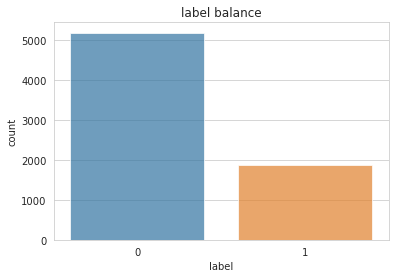

In [18]:
sns.countplot(x=data['contract']['label'], alpha=0.7)
plt.title('label balance')
plt.show()

Классы разбалансированы.

In [19]:
label = data['contract']['label']

Посмотрим, сколько клиенты пользуются тарифом:

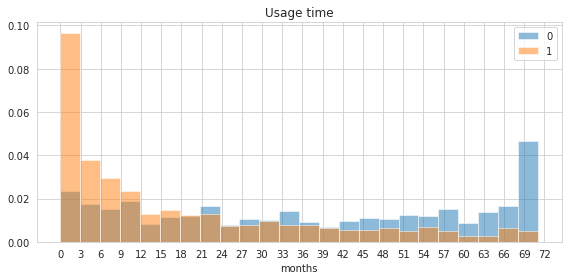

In [20]:
plt.figure(figsize=(8,4))
n_bins = 24
plt.hist(data['contract'].loc[label == 0, 'usage_time'], alpha=0.5, label='0', bins=n_bins, density=True)
plt.hist(data['contract'].loc[label == 1, 'usage_time'], alpha=0.5, label='1', bins = n_bins, density=True)
plt.legend()
plt.xticks(range( 0, 74, 3))
plt.title('Usage time')
plt.xlabel('months')
plt.tight_layout()
plt.show()

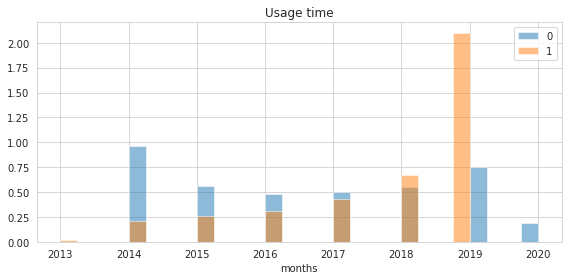

In [21]:
plt.figure(figsize=(8,4))
n_bins = 24
plt.hist(data['contract'].loc[label == 0, 'begin_year'], alpha=0.5, label='0', bins=n_bins, density=True)
plt.hist(data['contract'].loc[label == 1, 'begin_year'], alpha=0.5, label='1', bins = n_bins, density=True)
plt.legend()
plt.title('Usage time')
plt.xlabel('months')
plt.tight_layout()
plt.show()

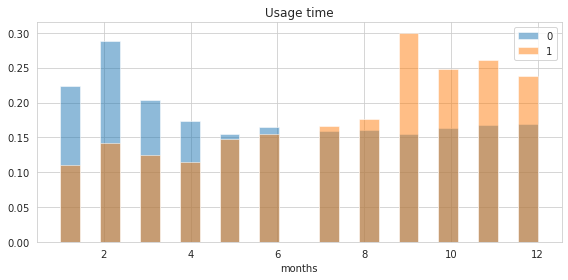

In [22]:
plt.figure(figsize=(8,4))
n_bins = 24
plt.hist(data['contract'].loc[label == 0, 'begin_month'], alpha=0.5, label='0', bins=n_bins, density=True)
plt.hist(data['contract'].loc[label == 1, 'begin_month'], alpha=0.5, label='1', bins = n_bins, density=True)
plt.legend()
plt.title('Usage time')
plt.xlabel('months')
plt.tight_layout()
plt.show()

Видно, что больше всего ушедших клиентов - в последние несколько месяцев. Соответственно, по числу ушедших лидирует 2019 год и его последние месяцы. Эту информацию сразу из модели уберу, т.к. иначе она будет немасштабируемой: через несколько месяцев распределение уходящих клиентов по годам и месяцам изменитcя. Валидный признак здесь - "время жизни" клиента. Даты начала и окончания пользования тоже сразу уберу.

In [23]:
data['contract'] =\
data['contract'].drop(columns = ['BeginDate', 'EndDate', 'begin_month', 'end_month', 'begin_year', 'end_year'])

In [24]:
data['contract'].head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,usage_time,label
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,34,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,2,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,45,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,2,1


Проверю, отличаются ли по платежам ушедшие и оставшиеся клиенты:

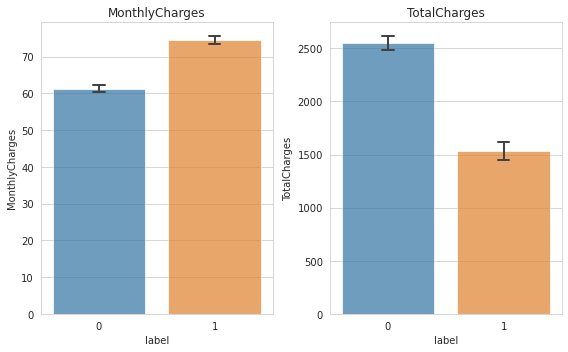

In [25]:
fig, axs = plt.subplots(1,2,figsize=(8,5))
cols = ['MonthlyCharges', 'TotalCharges']
for ax, col in zip(axs, cols):
    ax.set_title(col)
    sns.barplot(data = data['contract'], x='label', y=col, ax=ax, 
            capsize=.1, errwidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

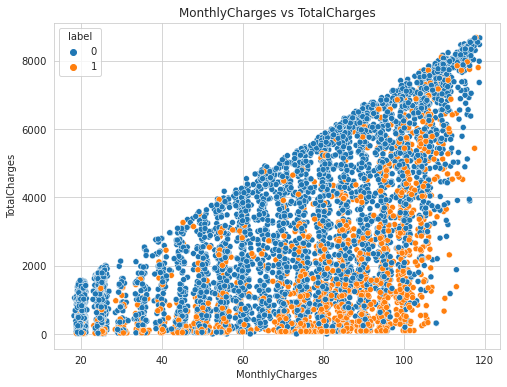

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data =data['contract'], x='MonthlyCharges', y='TotalCharges', hue = 'label')
plt.title('MonthlyCharges vs TotalCharges')
plt.show()

И по barplot, и по scatterplot видно, что ушедшие клиенты сосредоточены больше в зоне высоких месячных платежей. Проверю статистически значимые различия. Нулевая гипотеза - средние значения месячных и общих платежей у ушедших и лояльных клиентов не различаются. Уровень значимости выберу 0,05.

In [27]:
for col in cols:
    print(col)
    x = data['contract'].loc[ label == 0, col]
    y = data['contract'].loc[ label == 1, col]
    print(AB_permutation_test(x, y, par='means', iterations=10000))

MonthlyCharges
AB_PermutationResult(means_difference=-13.176208567842295, iterations=10000, pvalue=0.0)
TotalCharges
AB_PermutationResult(means_difference=1018.115347656503, iterations=10000, pvalue=0.0)


Отвергаем для обоих случаев нулевую гипотезу с p-значением 0 < 0.05 (в перестановочном тесте ни в одном случает из 10000 разность средних не была больше, чем в нашем случае).

Т.е. ушедшие и лояльные клиенты отличаются по средним уровням платежей. Месячные платежи в группе лояльных клиентов в среднем ниже, а годовые в среднем - выше (что логично, т.к. уходящие клиенты имеют меньшее "время жизни" и не успевают внести достаточно годовых платежей).

<h2 style="color:DodgerBlue">1.3 Объединение наборов данных, продолжение анализа</h2>

Объединю датасеты:

In [28]:
df = data['contract'].merge(data['personal'], on='customerID', how='outer')

In [29]:
df = df.merge(data['phone'], on='customerID', how='outer')

In [30]:
df = df.merge(data['internet'], on='customerID', how='outer')

Индексами назанчу id клиентов

In [31]:
df.index = df['customerID']

In [32]:
df.drop(columns = ['customerID'], inplace = True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   usage_time        7043 non-null   int64  
 6   label             7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  MultipleLines     6361 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

У части клиентов нет данных об интеренет услугах, у части - об услугах телефонной связи (подключен ли к нескольким линиям одновременно). Видимо, они не пользуются этими услугами. 
Посмотрю, что пользуется обоими типами услуг, а кто - только одним из типов.

In [34]:
phone_inet = \
set(data['phone']['customerID'].values) & set(data['internet']['customerID'].values)
phone = set(data['phone']['customerID'].values) - phone_inet
inet = set(data['internet']['customerID'].values) - phone_inet

In [35]:
print('Пользуются и телефоном и интернетом', len(phone_inet))
print('Пользуются только телефоном', len(phone))
print('Пользуются только интернетом', len(inet))
print('Всего пользователей', len(phone_inet) + len(phone) + len(inet))

Пользуются и телефоном и интернетом 4835
Пользуются только телефоном 1526
Пользуются только интернетом 682
Всего пользователей 7043


In [36]:
print('Только телефон, доля ушедших', round(df.loc[phone, 'label'].value_counts()[1] / df.loc[phone, 'label'].value_counts()[0], 2))
print('Только интернет, доля ушедших', round(df.loc[inet, 'label'].value_counts()[1] / df.loc[inet, 'label'].value_counts()[0], 2))
print('Оба типа услуг, доля ушедших', round(df.loc[phone_inet, 'label'].value_counts()[1] / df.loc[phone_inet, 'label'].value_counts()[0], 2))
print('Все клиенты, доля ушедших', round(df['label'].value_counts()[1] / df['label'].value_counts()[0], 2))

Только телефон, доля ушедших 0.08
Только интернет, доля ушедших 0.33
Оба типа услуг, доля ушедших 0.49
Все клиенты, доля ушедших 0.36


Меньше всего уходят клиенты, использующие только телефон. Больше всего - использующие обе услуги. Возможно, эти пользователи наиболее активны и требовательны.

Вообще, есть три группы пользователей, которые, возможно, отличаются предпочтениями, требованиями и поведением. Особенно выделяются те, кто пользуется только стационарным телефоном. Возможно, для каждой группы нужно делать свою модель. Но одельные группы немногочисленны и успех сомнителен.

In [37]:
categorical_features = []
for col in df.columns:
    if df[col].dtype == 'O':
        categorical_features.append(col)

In [38]:
categorical_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [39]:
categorical_features.append('SeniorCitizen')

In [40]:
12 % 3

0

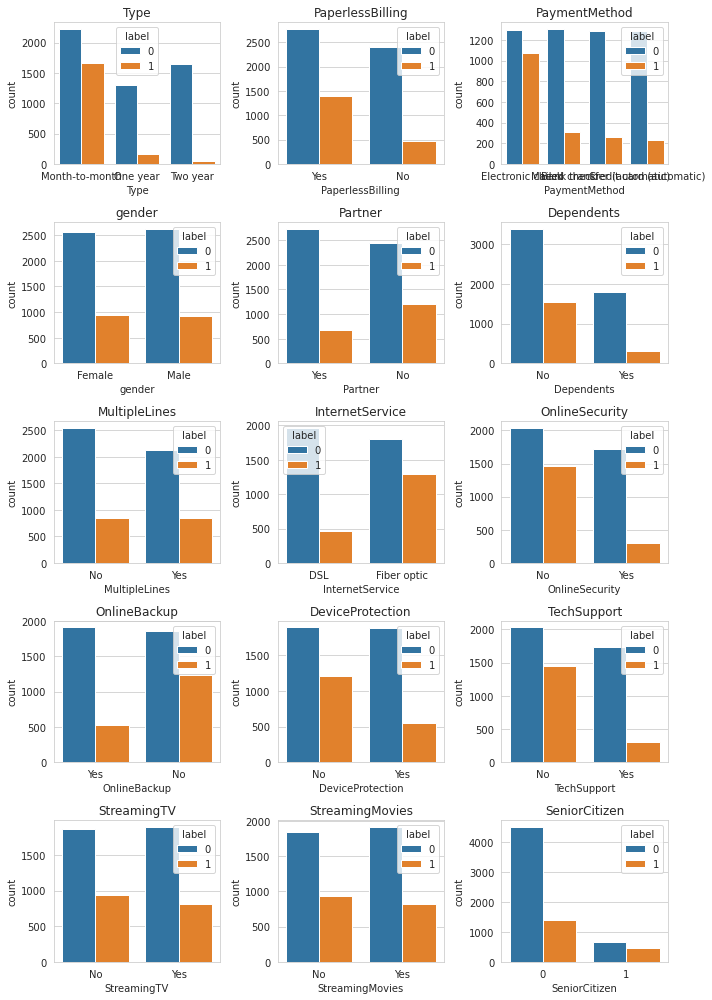

In [41]:
fig, axs = plt.subplots(
    (len(categorical_features) // 3) + ((len(categorical_features) % 3) > 0),
    3,
    figsize = (10,14)
)
axs.flatten()
i = 0
for feature in categorical_features:
    ax = axs.flatten()[i]
    ax.set_title(feature)
    sns.countplot(x = df[feature], hue=df['label'], ax=ax)
    i += 1
plt.tight_layout()
plt.show()

<h1 style="color:SteelBlue; font-size:200%">Вывод из анализа данных</h1>

Данные из состоят из 4 файлов, дублей нет ни в строках, ни в идентификаторах пользователей. Классы разбалансированы (примерно 1 к 3 в пользу 0). 

Больше всего ушедших клиентов - в последние несколько месяцев, т.е. чаще уходят новые клиенты. Ушедшие клиенты сосредоточены больше в зоне высоких месячных платежей. Средние месячные платежи в группе ушедших клиентов ниже, а средние годовые - выше (p = 0.0 < alpha = 0.05). 

В выборке есть пользователи только телефона, только интернета и обоих типов услуг. Меньше всего уходят клиенты, использующие только телефон. Больше всего - использующие обе услуги. 

Похоже, уходящие клиенты - это довольно современные люди, которые пользуются электронными чеками и платят ежемесячно. Среди них большинство подключено по оптоволокну и не пользуется услугами Security, BackUp, Protection, Support. А вот по признакам StreamingTV и StreamingMovies серьёзных отличий не видно. Что интересно, доля ушедших клиентов среди пожилых крайне высока, почти половина.

<h1 style="color:SteelBlue; font-size:200%">План решения задачи</h1>

1. Feature engineering (при необходимости) 
2. Разбиение выборки на тренировочную и тестовую
3. Создание нескольких вариантов pipeline (imputer+encoder+model). 
Предполагаю начать с бустинга на решающих деревьях (XGBoost, CatBoost, LightGBM). Тогда imputer - самые частые значения, нехарактерные значения или без заполнения. Encoder - какой-то вариант из category_encoders: TargetEncoder, OrdinalEncoder, CountEncoder. Для пользователей только телефона возможна отдельная модель.
4. Предварительная настройка гиперпараметров, кросс-валидация pipeline на тренировочной выборке. Подстройка параметров и выбор оптимального pipeline. 
5. Fine tuning гиперпараметров выбранного pipeline на кросс-валидации.
6. Проверка модели на тестовой выборке

<h1 style="color:SteelBlue; font-size:200%">2. Машинное обучение</h1>

На этапе анализа выяснил, что есть 3 группы пользователей: те, кто пользуется только телефоном, только интеренетом и тем и другим. Добавлю соответствующие метки и подготовлю матрицу признаков и вектор целевой переменной.

In [42]:
df.loc[:, 'use_services'] = 'phone_inet'
df.loc[phone, 'use_services'] = 'phone'
df.loc[inet, 'use_services'] = 'inet'

Пробовал также категоризовать время жизни пользователя (до 3 мес., 3-12 мес., 12 и более мес.), но это ухудшило метрики. Аналогично - бинаризация payment_method и type. Попытки oversampling с [imbalanced learn](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) также не помогли.

In [43]:
X,y = df.drop(columns=['label']), df['label']

In [44]:
X.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,usage_time,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,use_services
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,inet
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,34,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,phone_inet
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,2,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,phone_inet
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,45,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,inet
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,2,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,phone_inet


Выделю количественные и категориальные признаки, среди категориальных - бинарные и с большим числом категорий.

In [45]:
binary_features = []
for col in X.columns:
    if (len(X.loc[~X[col].isna(), col].unique()) == 2) and (X[col].dtype == 'O'):      
        binary_features.append(col)
binary_features.append('SeniorCitizen')
print('Категориальные признаки (бинарные)')
print(binary_features, 'Всего', len(binary_features))

Категориальные признаки (бинарные)
['PaperlessBilling', 'gender', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen'] Всего 13


In [46]:
multicat_features = []
for col in X.columns:
    if (len(X.loc[~X[col].isna(), col].unique()) > 2) and (X[col].dtype == 'O'):      
        multicat_features.append(col)
print('Категориальные признаки (больше 2 категорий):')
print(multicat_features)

Категориальные признаки (больше 2 категорий):
['Type', 'PaymentMethod', 'use_services']


In [47]:
quantitive_features = []
for col in X.columns:
    if (len(X.loc[~X[col].isna(), col].unique()) > 2) and (X[col].dtype != 'O'):      
        quantitive_features.append(col)
print('Количественные признаки:')
print(quantitive_features)

Количественные признаки:
['MonthlyCharges', 'TotalCharges', 'usage_time']


In [48]:
cat_features = np.append(binary_features, multicat_features)
print('Все категориальные признаки:')
print(cat_features, 'Всего', len(cat_features))

Все категориальные признаки:
['PaperlessBilling' 'gender' 'Partner' 'Dependents' 'MultipleLines'
 'InternetService' 'OnlineSecurity' 'OnlineBackup' 'DeviceProtection'
 'TechSupport' 'StreamingTV' 'StreamingMovies' 'SeniorCitizen' 'Type'
 'PaymentMethod' 'use_services'] Всего 16


Пропуски заполню 'missing_value'

In [49]:
X = X.fillna('missing_value')

Сменю тип категориальных переменных на category.

In [50]:
X = X[cat_features].astype('category').join(X[quantitive_features])
X.head()

,PaperlessBilling,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Type,PaymentMethod,use_services,MonthlyCharges,TotalCharges,usage_time
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Yes,Female,Yes,No,missing_value,DSL,No,Yes,No,No,No,No,0,Month-to-month,Electronic check,inet,29.85,29.85,1
5575-GNVDE,No,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,0,One year,Mailed check,phone_inet,56.95,1889.50,34
3668-QPYBK,Yes,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,0,Month-to-month,Mailed check,phone_inet,53.85,108.15,2
7795-CFOCW,No,Male,No,No,missing_value,DSL,Yes,No,Yes,Yes,No,No,0,One year,Bank transfer (automatic),inet,42.30,1840.75,45
9237-HQITU,Yes,Female,No,No,No,Fiber optic,No,No,No,No,No,No,0,Month-to-month,Electronic check,phone_inet,70.70,151.65,2


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify=y, random_state=27)

Попробую обучить Catboost, LGBM, XGBoost, RandomForest, ExtraTrees, KNN и Logistic Regression. Попробую стек этих моделей.

In [52]:
cv_params = {'max_depth': 3,
             'eta': 0.1,
             'n_estimators': 300,
             'subsample': .8,
             'loss_function': 'Logloss',
             'eval_metric': 'AUC',
             'random_state': 27,
             'auto_class_weights': 'SqrtBalanced',
             'verbose':0}

cv_dataset = Pool(data=X_train, label=y_train, cat_features = cat_features)

# scores = cv(cv_dataset,
#             cv_params,
#             stratified = True,
#             fold_count=5,
#             plot="True")

In [53]:
cb_params = {'max_depth': 3,
             'eta': 0.1,
             'n_estimators': 300,
             'subsample': .8,
             'loss_function': 'Logloss',
             'eval_metric': 'AUC',
             'auto_class_weights': 'SqrtBalanced',
             'cat_features': cat_features,
             'random_state': 27,
             'verbose':0}

cb_model = CatBoostClassifier(**cb_params)
cross_val_score(cb_model, X_train, y_train, scoring='roc_auc')

array([0.85518153, 0.86455091, 0.86692282, 0.86441139, 0.84069938])

In [54]:
lgbm_params = {'num_leaves': 6,
               'n_estimators': 300,
               'learning_rate':0.1,
               'metric': 'AUC', 
               'random_state': 27}

lgb_model = LGBMClassifier(**lgbm_params)

cross_val_score(lgb_model, X_train, y_train, scoring='roc_auc')

array([0.85504038, 0.86510006, 0.86091435, 0.85481465, 0.83571659])

In [55]:
ct_xgb = ColumnTransformer([
    ("bin_encoder", OrdinalEncoder(), binary_features),
    ("mul_encoder", OrdinalEncoder(), multicat_features),
    ("scaler", StandardScaler(), quantitive_features)
                       ])

w1 = 0.7
w_array = np.array([1]*y_train.shape[0])
w_array[y_train==1] = w1
w_array[y_train==0] = 1- w1

xgb_params = {'max_depth': 3,
              'eta': 0.05,
              'n_estimators': 500,
              'subsample': 0.8,
              'eval_metric': 'auc',
              'random_state': 27,
              'use_label_encoder':False
             }

xgb_model = XGBClassifier(**xgb_params)



pipe_xgb = Pipeline(steps = [('transformer', ct_xgb),
                             ('model', xgb_model)])

cross_val_score(pipe_xgb, X_train, y_train, scoring='roc_auc')

array([0.85395405, 0.86548823, 0.86193216, 0.85930446, 0.83850911])

In [56]:
ct_rf = ColumnTransformer([
    ("bin_encoder", OrdinalEncoder(), binary_features),
    ("mul_encoder", OrdinalEncoder(), multicat_features),
    ("scaler", StandardScaler(), quantitive_features)
                       ])

rf_model = RandomForestClassifier(class_weight='balanced',
                                random_state=27,
                                max_depth=6,
                                n_estimators=500)

pipe_rf = Pipeline(steps = [('transformer', ct_rf),
                                ('model', rf_model)])

cross_val_score(pipe_rf, X_train, y_train, scoring='roc_auc')

array([0.85099342, 0.85280944, 0.86270848, 0.86042959, 0.83490644])

In [57]:
ct_et = ColumnTransformer([
    ("bin_encoder", OrdinalEncoder(), binary_features),
    ("mul_encoder", OrdinalEncoder(), multicat_features),
    ("scaler", StandardScaler(), quantitive_features)
                       ])

et_model = ExtraTreesClassifier(class_weight='balanced',
                                random_state=27,
                                max_depth=6,
                                n_estimators=100)

pipe_et = Pipeline(steps = [('transformer', ct_et),
                                ('model', et_model)])

cross_val_score(pipe_et, X_train, y_train, scoring='roc_auc')

array([0.84110385, 0.84146686, 0.85620631, 0.8483876 , 0.82539253])

In [58]:
ct_knn = ColumnTransformer([
    ("bin_encoder", OrdinalEncoder(), binary_features),
    ("mul_encoder", OneHotEncoder(), multicat_features),
    ("scaler", StandardScaler(), quantitive_features)
                       ])

knn_model = KNeighborsClassifier(n_neighbors=200, weights='uniform')

pipe_knn = Pipeline(steps = [('transformer', ct_knn),
                                ('model', knn_model)])

cross_val_score(pipe_knn, X_train, y_train, scoring='roc_auc')

/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: Future

array([0.8339444 , 0.83267328, 0.85068975, 0.84740736, 0.8236145 ])

In [59]:
ct_logreg = ColumnTransformer([
    ("bin_encoder", OrdinalEncoder(), binary_features),
    ("mul_encoder", OneHotEncoder(), multicat_features),
    ("scaler", StandardScaler(), quantitive_features)
                       ])
logreg = LogisticRegression(solver='liblinear',
                                max_iter=10000, 
                                C=0.7, 
                                class_weight = 'balanced',
                                random_state = 27
                               )
pipe_logreg = Pipeline(steps = [('transformer', ct_logreg),
                                ('model', logreg)])

cross_val_score(pipe_logreg, X_train, y_train, scoring='roc_auc')

/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: Future

array([0.84575293, 0.85035167, 0.85390416, 0.85609719, 0.83453721])

Теперь попробую стек моделей. Обучающую выборку разобью пополам, на первой половине обучу модели и предскажу целевой признак для второй половины. На предсказаниях и целевом признаке второй половины выборки обучу мета-модель. Предскажу целевые переменные для теста и метамоделью сделаю финальный прогноз.

In [60]:
models_list = [cb_model, lgb_model, pipe_xgb, pipe_rf, pipe_et, pipe_knn, pipe_logreg]

In [61]:
X_meta_1, X_meta_2, y_meta_1, y_meta_train = train_test_split(X_train, y_train,
                                                       stratify = y_train,
                                                       test_size = 0.5,
                                                       random_state = 27)

In [62]:
meta_features_train = []
for model in models_list:
    model.fit(X_meta_1, y_meta_1)
    meta_features_train.append(model.predict_proba(X_meta_2)[:, 1])

/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [63]:
X_meta_train = pd.DataFrame(np.array(meta_features_train).T)
X_meta_train.head()

,0,1,2,3,4,5,6
0,0.766520,0.702699,0.758121,0.712145,0.683821,0.415,0.864413
1,0.110864,0.091615,0.086879,0.214067,0.256383,0.060,0.091977
2,0.419738,0.163525,0.276012,0.475963,0.480262,0.245,0.519424
3,0.514196,0.467874,0.451793,0.572875,0.676939,0.530,0.644206
4,0.543573,0.433031,0.367107,0.639057,0.687358,0.595,0.733290


In [64]:
meta_model = LogisticRegression(solver='liblinear',
                                max_iter=10000, 
                                C=0.01, 
                                class_weight = {}
                               )

cross_val_score(meta_model, X_meta_train, y_meta_train, scoring='roc_auc', cv=3)

array([0.88372931, 0.85882519, 0.85490772])

**В итоге мета-модель показывает результат, аналогичный CatBoost. CatBoost также один из лучших бустингов. Возьму CatBoost в качестве финальной модели.**

In [65]:
#удаляю признаки с наименьшей feature_importance (результат на кросс-валидации чуть более стабилен)
to_drop = ['Partner', 'use_services', 'DeviceProtection', 'Dependents']

cat_features_cleaned = list(set(cat_features) - set(to_drop))

cb_params = {'max_depth': 3,
             'eta': 0.1,
             'n_estimators': 300,
             'subsample': .8,
             'loss_function': 'Logloss',
             'eval_metric': 'AUC',
             'auto_class_weights': 'SqrtBalanced',
             'cat_features': cat_features_cleaned,
             'random_state': 27,
             'verbose':0}

X_train_cleaned = X_train.drop(columns = to_drop)
cb_model = CatBoostClassifier(**cb_params)
cross_val_score(cb_model, X_train_cleaned, y_train, scoring='roc_auc')

array([0.85469733, 0.86217722, 0.86766516, 0.86681013, 0.84192895])

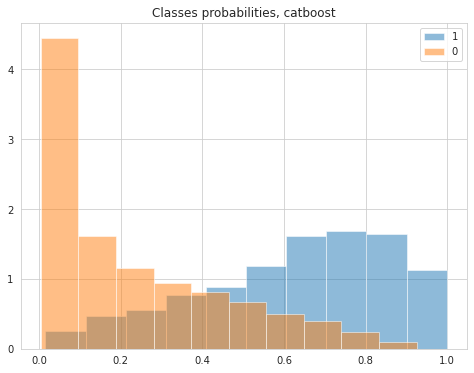

In [66]:
cb_model.fit(X_train_cleaned, y_train)
y_train_proba = cb_model.predict_proba(X_train_cleaned)
plt.figure(figsize=(8, 6))
plt.hist(y_train_proba[:,1][y_train==1], density=True, alpha=.5, label='1')
plt.hist(y_train_proba[:,1][y_train==0], density=True, alpha=.5, label='0')
plt.legend()
plt.title('Classes probabilities, catboost')
plt.show()

In [67]:
y_test_proba = cb_model.predict_proba(X_test.drop(columns=to_drop))

Порог предсказания установил 0.4, ориентируясь на пересечение плотностей распределения. Поскольку лучше ошибочно принять клиента за уходящего, чем упустить, немного сместил баланс в сторону recall от precision.

In [68]:
threshold = 0.4
print_report(y_test, y_test_proba[:, 1], threshold)

,Predicted NO,Predicted YES
Actual NO,611,166
Actual YES,61,219


---------------------------report---------------------------

               precision    recall  f1-score   support

           0       0.91      0.79      0.84       777
           1       0.57      0.78      0.66       280

    accuracy                           0.79      1057
   macro avg       0.74      0.78      0.75      1057
weighted avg       0.82      0.79      0.79      1057

ROC_AUC: 0.87
ACCURACY: 0.79


<h1 style="color:SteelBlue; font-size:200%">Результаты машинного обучения</h1>

В машинном обучении рассмотрел 7 классификаторов (Catboost, LGBM, XGBoost, RandomForest, ExtraTrees, KNN и Logistic Regression), а также попробовал стек из них и мета-модель логистической регрессии. 

Для полноценного стека мало данных. Возможно, на большем количестве данных стек показал бы себя лучше (на одной из кросс-валидаций AUC стека была 0.88). Попытки oversampling с [imbalanced learn](https://imbalanced-learn.org/stable/over_sampling.html#smote-variants) (SMOTE) также ничего не дали.

На основе результатов кросс-валидаций классификаторов выбрал CatBoost. На тестовой выборке он показал **ROC_AUC: 0.87 и ACCURACY: 0.79** (при попроге предсказания 0.4). Из 280 уходящих клиентов модель пропустила 61 и ложно сработала на 166. Верно определены 219 уходов.

Финальная модель:

In [69]:
print('Модель:', cb_model) 
print('Количество деревьев:', cb_model.tree_count_)
print('Learning rate:', cb_model.learning_rate_)
pd.DataFrame(cb_model.feature_importances_, 
             index = cb_model.feature_names_,
             columns = ['importance']).sort_values(by='importance', ascending=False)

Модель: <catboost.core.CatBoostClassifier object at 0x7f71a092cd90>
Количество деревьев: 300
Learning rate: 0.10000000149011612


,importance
usage_time,31.146041
Type,24.391729
MonthlyCharges,12.820498
TotalCharges,9.006542
OnlineSecurity,4.142118
TechSupport,4.132668
PaymentMethod,3.800028
InternetService,2.657620
MultipleLines,1.941720
PaperlessBilling,1.541842


<h1 style="color:SteelBlue; font-size:200%">Отчёт по работе</h1>

Работа и её ключевые шаги в целом соответствуют плану. Сделал лёгкий feature engineering (добавил признак `use services`, попробовал категоризовать время жизни пользователя и бинаризовать `payment_method` и `type`). При проверке значимости признаков и их влияния на метрики выяснил, что все эти признаки и модификации не нужны.

Заполнил пропуски значениями `unknown_value`, выборку разбил на тренировочную и тестовую. Чтобы построить метапризнаки тренировочную также разбил на две части. Обучил несколько моделей в рамках отдельных pipeline, на их базе построил метапризнаки и на них обучил метамодель.

Предварительную настройку гиперпараметров выполнил при кросс-валидации пайплайнов на тренировочной выборке. По результатам кросс-валидаций выбрал оптимальную модель: `CatBoostClassifier (max_depth': 3, 'eta': 0.1, 'n_estimators': 300, 'subsample': .8, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'auto_class_weights': 'SqrtBalanced')`

Проверил feature importances, удалил малозначимые признаки (`'Partner', 'use_services', 'DeviceProtection', 'Dependents'`). Топ 4 признаков по важности: `usage_time, Type, MonthlyCharges, TotalCharges`. Чтобы сбалансировать точность и полноту настроил порог вероятности для классификации пользователей (выбрал порог 0.4). 

Протестировал модель на отложенной тестовой выборке. Получил **ROC_AUC: 0.87 и ACCURACY: 0.79** (при пороге предсказания 0.4). Из 280 уходящих клиентов модель пропустила 61 и ложно сработала на 166. Верно определены 219 уходов.